In [1]:
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
words = open("/content/names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [2]:
# Import necessary libraries
import torch
import random

# Define your dataset
block_size = 4  # You can change this block size if needed

# Step 1: Preprocessing - Creating a character vocabulary and mapping
# Sort all unique characters in your dataset and assign an index to each character
chars = sorted(list(set("".join(words))))  # Get all unique characters from your words
stoi = {s: i + 1 for i, s in enumerate(chars)}  # Create a mapping from character to index
stoi["."] = 0  # Add a special character '.' with index 0
itos = {i: s for s, i in stoi.items()}  # Create a reverse mapping from index to character

# Step 2: Building the dataset
def build_dataset(words, block_size=block_size):
    X, Y = [], []

    for w in words:
        context = [0] * block_size  # Initialize a context list with zeros
        for ch in w + '.':  # Loop through each character in the word and add a period at the end

            ix = stoi[ch]  # Get the index of the current character

            X.append(context)  # Append the context (previous characters) to X
            Y.append(ix)  # Append the index of the current character to Y

            context = context[1:] + [ix]  # Update the context by shifting and adding the current character's index

    X = torch.tensor(X)  # Convert X to a PyTorch tensor
    Y = torch.tensor(Y)  # Convert Y to a PyTorch tensor
    print(X.shape, Y.shape)  # Print the shape of X and Y for verification
    return X, Y

# Shuffle the words for randomization
random.seed(42)
random.shuffle(words)

# Split the dataset into training, development, and testing sets
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # Training set
Xdev, Ydev = build_dataset(words[n1:n2])  # Development set
Xte, Yte = build_dataset(words[n2:])  # Testing set


torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


E01: Tune the hyperparameters of the training to beat validation loss of 2.2

In [7]:
# Hyperparameters
emb_size = 12
in_size = block_size * emb_size
hidden_size = 256
out_size = 27
max_iterations= 290000

lr = 0.1
lambda_ = 0.01
batch_size = 256

In [4]:
# Create a random number generator with a specific seed for reproducibility
g = torch.Generator().manual_seed(12344321)

# Initialize weight matrices and bias vectors with random values using the specified generator
C = torch.randn((out_size, emb_size), generator=g)  # Output layer weights
W1 = torch.randn((in_size, hidden_size), generator=g)  # Input to hidden layer weights
b1 = torch.randn(hidden_size, generator=g)  # Hidden layer bias
W2 = torch.randn((hidden_size, out_size), generator=g)  # Hidden to output layer weights
b2 = torch.randn(out_size, generator=g)  # Output layer bias

# Create a list containing all the parameters (weights and biases) you want to optimize
parameters = [C, W1, b1, W2, b2]

# Print the total number of parameters in your model
print(f"number of params = {sum(p.nelement() for p in parameters)}")

# Set requires_grad=True for all parameters, indicating that gradients will be calculated during training
for p in parameters:
    p.requires_grad = True

# Initialize empty lists for storing loss and step values (assuming they will be used later in your code)
lossi = []
stepi = []


number of params = 19807


In [5]:
# Training Loop
for i in range(300000):

    # Sample a random minibatch of indices for training data
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward Pass
    emb = C[Xtr[ix]]  # Embedding layer
    h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)  # Hidden layer with tanh activation
    logits = h @ W2 + b2  # Logits (output) layer

    # Calculate the loss using cross-entropy with regularization
    loss = F.cross_entropy(logits, Ytr[ix])

    # Add regularization terms to the loss
    loss += lambda_ * (W1 ** 2).mean() + lambda_ * (W2 ** 2).mean()

    # Backward Pass
    for p in parameters:
        p.grad = None  # Clear gradients before backward pass

    loss.backward()  # Compute gradients via backpropagation

    # Adjust the learning rate based on the current iteration
    used_lr = lr
    if i > 20000 and i < 60000:
        used_lr = 0.01
    elif i >= 200000:
        used_lr = 0.001
    elif i >= 260000:
        used_lr = 0.0001

    # Update the model parameters using the calculated gradients and adjusted learning rate
    for p in parameters:
        p.data -= used_lr * p.grad

    # Track the loss and step
    lossi.append(loss.log10().item())
    stepi.append(i)

    # Print the loss and learning rate at certain intervals
    if i % 10000 == 0:
        print(f"mini batch {i} | loss {loss.item()} at lr {used_lr}")


mini batch 0 | loss 30.281293869018555 at lr 0.1
mini batch 10000 | loss 2.3724091053009033 at lr 0.1
mini batch 20000 | loss 2.2904064655303955 at lr 0.1
mini batch 30000 | loss 2.2936646938323975 at lr 0.01
mini batch 40000 | loss 2.1645283699035645 at lr 0.01
mini batch 50000 | loss 2.013986110687256 at lr 0.01
mini batch 60000 | loss 2.183695077896118 at lr 0.1
mini batch 70000 | loss 2.2600300312042236 at lr 0.1
mini batch 80000 | loss 2.2634193897247314 at lr 0.1
mini batch 90000 | loss 2.115208625793457 at lr 0.1
mini batch 100000 | loss 2.0860471725463867 at lr 0.1
mini batch 110000 | loss 2.2299885749816895 at lr 0.1
mini batch 120000 | loss 2.2370123863220215 at lr 0.1
mini batch 130000 | loss 2.2087697982788086 at lr 0.1
mini batch 140000 | loss 2.3046255111694336 at lr 0.1
mini batch 150000 | loss 2.214862585067749 at lr 0.1
mini batch 160000 | loss 2.1576220989227295 at lr 0.1
mini batch 170000 | loss 2.14815354347229 at lr 0.1
mini batch 180000 | loss 2.174960136413574 at

Training set loss 4.479013442993164
Dev set loss 4.515892028808594


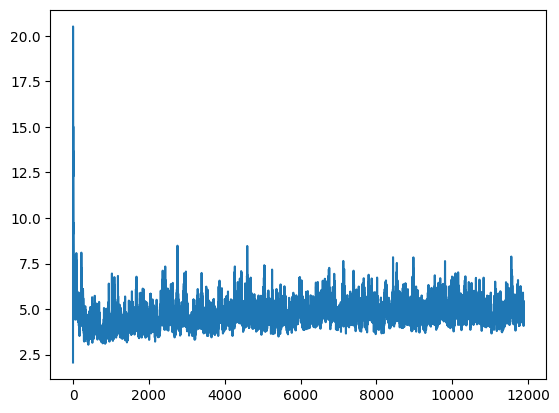

In [9]:
# Evaluation

# 1) Training Loss
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# 2) Test Loss
# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

# 3) Plot Mini Batch Loss[]
plt.plot(lossi);

E02: intialization of the network.
(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

In [11]:
torch.nn.init.normal_(C, 0, 0.01)
torch.nn.init.normal_(W1, 0, 0.01)
torch.nn.init.normal_(b1, 0, 0.01)
torch.nn.init.normal_(W2, 0, 0.01)
torch.nn.init.normal_(b2, 0, 0.01)

# use Xtr and Ytr
X = Xtr
Y = Ytr

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

number of params = 19807


In [10]:
# Evaluation
# 1) Training Loss
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# 2) Dev Loss
# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, in_size) @ W1 + b1)
logits = h @ W2 + b2
torch.nn.init.uniform_(logits, 0, 1)
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

Training set loss 3.3353917598724365
Dev set loss 3.3355441093444824
